## 1.文件读取
notes:
- !shell command 可以再 jupyter 里面执行 shell 命令
- wiki 数据提取
- pandas读取文件。常见中文编码方式（e.g. 'gb18030'）。
- pandas对表中数据进行filter（titanic_train）
- read from pickle

## 2.正则表达式
- html 文件中用正则抓取 http url

## 3.n-gram
用n-gram计算句子、短语的概率
### 3.1 词频统计 (BOW)
- calculation of BOW see **corpus_processing_doc.ipynb**
- 生成可以统计词频的函数的函数（lisp风格的变量作用于trick）
- 画出词频的分布曲线

============= 1-gram char =============
total word count of corpus: 389334319
total vocabulary count: 9727
============= 2-gram char =============
total word count of corpus: 355228867
total vocabulary count: 948930
============= 1-gram word =============
total word count of corpus: 158096450
total vocabulary count: 296756
============= 2-gram word =============
total word count of corpus: 63557530
total vocabulary count: 749114


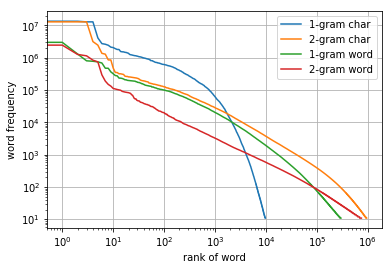

In [29]:
import matplotlib.pyplot as plt
import corpus_processing as cp
import debug_tools

count_ngram1word = cp.load_obj('data/count_ngram1word')
count_ngram2word = cp.load_obj('data/count_ngram2word')
count_ngram1char = cp.load_obj('data/count_ngram1char')
count_ngram2char = cp.load_obj('data/count_ngram2char')

legend = []
def visualize_counter(word_count, name):
    global legend
    legend.append(name)
    freq = [f for gram, f in word_count.most_common()]
    plt.figure('counter')
    plt.loglog(freq)
    plt.grid(True)
    plt.xlabel('rank of word')
    plt.ylabel('word frequency')
    plt.legend(legend)
    print('=============',name,'=============')
    print('total word count of corpus:', sum(freq))
    print('total vocabulary count:', len(freq))

visualize_counter(count_ngram1char,'1-gram char')
visualize_counter(count_ngram2char,'2-gram char')
visualize_counter(count_ngram1word,'1-gram word')
visualize_counter(count_ngram2word,'2-gram word')
plt.show()

### 3.2 unigram
$\textbf{w} = w_1...w_i...w_n$

$P(\textbf{w}) = \prod_{i=1}^nP(w_i)$

In [2]:
from functools import reduce, partial
import logging
import jieba
jieba.setLogLevel(logging.WARNING)

def get_MLE_prob_from_count(count):
    total_count = sum(count.values())
    @debug_tools.debug_print
    def get_prob(w):
        return count[w]/total_count
    return get_prob

def string_ngram_prob(string, prob_func, gram_level, n):
    cp.gram_level = gram_level # this will effect the behavior of 'tokenize_string'
    probs = [prob_func(tuple(token)) for token in cp.get_ngram(string, n)]
    
    if not probs: 
        probs = [0]
    return reduce(lambda x, y: x*y , probs)

get_1gram_prob_char = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1char), 
                              gram_level='char', n=1)

get_1gram_prob_word = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1word), 
                              gram_level='word', n=1)

test cases

In [3]:
pair = """前天晚上吃晚饭的时候
前天晚上吃早饭的时候""".split('\n')

pair2 = """正是一个好看的小猫
真是一个好看的小猫""".split('\n')

pair3 = """我无言以对，简直
我简直无言以对""".split('\n')

pairs = [pair, pair2, pair3, ['广州有一个地方叫做沥窖', '杭州有一个地方叫做西湖'], ['这是一个比较常见测试用例','这是一个比较罕见的测试用例']]

def test_pair(pairs, prob_func, name_func):
    print('test function:', name_func)
    for pair in pairs:
        print('===================================')
        for sent in pair:
            print(sent, prob_func(sent))
    print('\n\n')
debug_tools.is_debug = False
test_pair(pairs, get_1gram_prob_char, 'get_1gram_prob_char')
test_pair(pairs, get_1gram_prob_word, 'get_1gram_prob_word')

test function: get_1gram_prob_char
前天晚上吃晚饭的时候 3.8350439429256126e-31
前天晚上吃早饭的时候 7.724772467291999e-31
正是一个好看的小猫 1.4986935364748715e-20
真是一个好看的小猫 4.765632570447433e-21
我无言以对，简直 4.264824123041106e-23
我简直无言以对 4.264824123041106e-23
广州有一个地方叫做沥窖 1.55608515722977e-32
杭州有一个地方叫做西湖 6.877388847319173e-29
这是一个比较常见测试用例 3.9131441795345993e-32
这是一个比较罕见的测试用例 2.4603814628944908e-33



test function: get_1gram_prob_word
前天晚上吃晚饭的时候 1.3775281090495917e-21
前天晚上吃早饭的时候 1.2329156456060136e-25
正是一个好看的小猫 2.5761218816412435e-16
真是一个好看的小猫 3.2085032220958126e-17
我无言以对，简直 6.889372468843494e-16
我简直无言以对 6.889372468843495e-16
广州有一个地方叫做沥窖 0.0
杭州有一个地方叫做西湖 1.1078347651166538e-19
这是一个比较常见测试用例 2.44250978974669e-18
这是一个比较罕见的测试用例 6.306098352969772e-19





### 3.3 bigram
$P(\textbf{w}) = \prod_{i=1}^nP(w_i|w_{i-1})= \prod_{i=1}^n\frac{P(w_{i-1},w_{i})}{P(w_{i-1})}$

In [4]:
def get_conditional_prob(numerator_func, denominator_func):
    @debug_tools.debug_print
    def get_prob(token):
        condition_token = token[:-1]
        return numerator_func(token)/denominator_func(condition_token)
    return get_prob

conditional_prob_char = get_conditional_prob(get_MLE_prob_from_count(count_ngram2char), 
                                             get_MLE_prob_from_count(count_ngram1char))

conditional_prob_word = get_conditional_prob(get_MLE_prob_from_count(count_ngram2word), 
                                             get_MLE_prob_from_count(count_ngram1word))

get_2gram_prob_char = partial(string_ngram_prob, 
                              prob_func=conditional_prob_char, 
                              gram_level='char', n=2)

get_2gram_prob_word = partial(string_ngram_prob, 
                              prob_func=conditional_prob_word, 
                              gram_level='word', n=2)

test cases

In [8]:
is_debug = False
test_pair(pairs, get_2gram_prob_char, 'get_2gram_prob_char')
test_pair(pairs, get_2gram_prob_word, 'get_2gram_prob_word')

test function: get_2gram_prob_char
前天晚上吃晚饭的时候 8.044376701016833e-19
前天晚上吃早饭的时候 8.044176890731375e-20
正是一个好看的小猫 6.102808501188787e-14
真是一个好看的小猫 2.5383867920499992e-14
我无言以对，简直 6.91685929758551e-17
我简直无言以对 7.174041746396637e-18
广州有一个地方叫做沥窖 0.0
杭州有一个地方叫做西湖 2.4312412025640827e-17
这是一个比较常见测试用例 0.0
这是一个比较罕见的测试用例 0.0



test function: get_2gram_prob_word
前天晚上吃晚饭的时候 0.0
前天晚上吃早饭的时候 0.0
正是一个好看的小猫 0.0
真是一个好看的小猫 0.0
我无言以对，简直 0.0
我简直无言以对 0.0
广州有一个地方叫做沥窖 0.0
杭州有一个地方叫做西湖 0.0
这是一个比较常见测试用例 0.0
这是一个比较罕见的测试用例 0.0





## 3.Good–Turing frequency estimation
reference: https://www.wikiwand.com/en/Good%E2%80%93Turing_frequency_estimation|

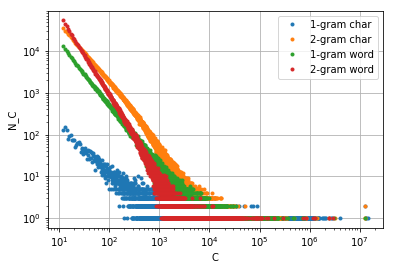

In [28]:
def get_Nc_from_c(c, count):
    selected_grams = list(filter(lambda x:x[1] == c, count.items()))
    return len(selected_grams)

legend = []
def visiualize_Nc_from_count(count, name):
#     c_max = count.most_common(1)[0][1]
#     N_c = [get_Nc_from_c(c, count) for c in range(c_max+1)] #too complex

    c = count.most_common(1)[0][1]
    N_c = 0
    Nc_pairs = []
    for gram, f in count.most_common():
        if f != c:
            Nc_pairs.append((c, N_c))
            c, N_c = f, 1
        else:
            N_c += 1
    c_list, Nc_list = tuple(zip(*Nc_pairs))
            
    
    legend.append(name)
    plt.figure('Nc')
    plt.loglog(c_list, Nc_list, '.')
    plt.xlabel('C')
    plt.ylabel('N_C')
    plt.grid(True)
    plt.legend(legend)

visiualize_Nc_from_count(count_ngram1char,'1-gram char')
visiualize_Nc_from_count(count_ngram2char,'2-gram char')
visiualize_Nc_from_count(count_ngram1word,'1-gram word')
visiualize_Nc_from_count(count_ngram2word,'2-gram word')
plt.show()

## 4.机器学习基础
- linear regression推导
- 实现梯度下降，及其可视化

assumption for linear regression:

$Y\sim N(wx,\sigma^2)\equiv P_{w,\sigma^2}(y|x) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left[-\frac{(y-wx)^2}{2\sigma^2}\right]$

MLE for all instanse in the training set with the size of n:

$\hat{w} = argmax_w \prod_{i=1}^n P_{w,\sigma^2}(y_i|x_i) = argmax_w \frac{1}{\sqrt{2\pi\sigma^2}}\prod_{i=1}^n exp\left[-\frac{(y_i-wx_i)^2}{2\sigma^2}\right]$

take logrithm on both sides:

$\hat{w} = argmax_w \sum_{i=1}^n - [(y_i-wx_i)^2 - 2\sigma^2] = argmin_w \sum_{i=1}^n (y_i-wx_i)^2 $



so linear regression model:

$y=\hat{w}x \qquad s.t. \quad \hat{w} =argmin_w \sum_{i=1}^n (y_i-wx_i)^2$

define the loss function:

$L(w) = \sum_{i=1}^n (y_i-wx_i)^2 = ||Xw-Y||^2 = ||N((\hat{w}-w)X,\sigma^2)||^2$

gradient of loss function

$\bigtriangledown L =\frac{\partial{L}}{\partial{w}} = 2X^T(Xw-Y)$

---

1.close form solution:

   $\bigtriangledown L = 0 \qquad \equiv \qquad  2X^T(Xw-Y) = 0$
   
   $X_{n*d},w_{d*1},Y_{n*1}$

   $w = (X^TX)^{-1}X^TY$

   complexity ananlysis:

   $temp1_{d*d} = X^TX \rightarrow O(n^{2.3728639})$

   $temp2_{d*d} = temp1^{-1}\rightarrow O(n^{2.3728639})$

   $temp3_{d*1}=X^TY \rightarrow O(n^{d*n*1})$

   $result = temp2*temp3 \rightarrow O(d*d*1)$

   overall complexity is $O(n^{2.3728639})$



---
2.gradient desent

   $w_{t+1}= w_{t}-\eta\bigtriangledown L $

   $w_{t+1}= w_{t}-\eta X^T(Xw-Y)$

   complexity ananlysis:

   $temp1_{n*1} = Xw \rightarrow O(n*d*1)$

   $temp2_{n*1} = temp1-Y \rightarrow O(n)$

   $gradient_{d*1} = X^Ttemp2 \rightarrow O(d*n*1)$

   repeat k iteration step

   Overall complexity is $O(k*d*n)$, where k<<n, d<<n



references of matrix computation: https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations



In [6]:
import numpy as np
X = np.random.normal(0,1,1000)
y = 

SyntaxError: invalid syntax (<ipython-input-6-8a1f7af93421>, line 3)